https://github.com/pranavphoenix/BiLSTM-POS-Tagging/blob/main/BiLSTM_POS_Tagging.ipynb

https://linguistics.stackexchange.com/questions/16897/unable-to-understand-meaning-of-tag-none-1-in-penn-treebank-example

TODO:
- Cacasburo
- Guardare creazione dizionario, bisogna rispettare i punti dell'assignment;
- Non togliere punctuation e symbols ma evitare di utilizzarli nel calcolo delle metriche, magari utilizzando l'array di pesi 'sample_weight' che si trova nell'altro notebook;
- Provare se i risultati migliorano con preprocessing (e.g. lowerando le parole);
- Aggiustare il notebook perché fa cagare;

# Assignment 1

**Due to**: 11/01/2022 (dd/mm/yyyy)

If you deliver it by 11/12/2021 your assignment will be graded by 11/01/2022.


**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

# Execution
## 0.1 Imports

In [52]:
import nltk
import numpy as np
import os
import re
import pandas as pd
import seaborn as sns
import tensorflow as tf
from collections import defaultdict, OrderedDict

import keras
from keras import backend as K
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, GRU, Embedding, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import urllib.request
import zipfile
import progressbar
from IPython.display import display_html
from itertools import chain,cycle
import plotly.graph_objs as go

## 0.2 Functions

In [82]:
# Downloading Glove Word Embeddings
pbar = None
def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

# Display dataframes
def display(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h4 style="text-align: left;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

#Compute embeddings based on the respective tag means.
def mean_embed4tag(df, tags, embedding_dict, embedding_dim):
  tag_dict = {tag:np.zeros(embedding_dim) for tag in tags}
  tag_count = {tag:0 for tag in tags}
  count = 0

  for idx, row in df.iterrows():
    for tag in tags:
      if tag == row['tag']:
        if row['word'] in embedding_dict:
            tag_count[tag] += 1
            tag_dict[tag] += embedding_dict[row['word']]

  for tag in tags:
    if np.all(tag_dict[tag]):
      tag_dict[tag] = tag_dict[tag] / tag_count[tag]
  print(f'Computed mean embeddings for {len(tags)} tags.')
  return tag_dict

  
    
#Update vocabulary
def update_vocab(df,embeddings_index,tag_dict,embedding_dim,seed=42): 
  oov_c = 0 
  cap_oov = 0
  np.random.seed(seed)
  for idx, row in df.iterrows():
    if row['word'] not in embeddings_index:
      if row['word'].lower() not in embeddings_index:
        oov_c += 1
        noise = np.random.normal(0, 0.0001, size=embedding_dim)
        embeddings_index[row['word']] = tag_dict[row['tag']] + noise       
      else:
        cap_oov += 1
        noise_c = np.random.normal(0, 0.000001, size=1)
        embeddings_index[row['word']] = embeddings_index[row['word'].lower()]
        embeddings_index[row['word']][0] = embeddings_index[row['word']][0] + noise_c
  print(f'Added {oov_c} OOV words + respective embeddings to the vocabulary.')
  print(f'Added {cap_oov} Capitalized words + respective embeddings to the vocabulary.')
  return embeddings_index

# Custom accuracy metric
def ignore_class_accuracy(classes=[0]):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
        
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32')
        for to_ignore in classes:
          ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
          matches = matches * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

def ignore_class_classification_report(y_true, y_pred, classes_to_ignore):
    mask = tf.math.not_equal(y_true, classes_to_ignore)
    y_true_filtered = tf.boolean_mask(y_true, mask)
    y_pred_filtered = tf.boolean_mask(y_pred, mask)
    return tf.metrics.classification_report(y_true_filtered, y_pred_filtered)

In [56]:
# Downloading the dataset
nltk.download('treebank')

# Download the GloVe embeddings file
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
urllib.request.urlretrieve(url, 'glove.6B.zip', show_progress)

# Extract the zip file
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall()
zip_ref.close()

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
100% (862182613 of 862182613) |##########| Elapsed Time: 0:02:39 Time:  0:02:39


## 1. Corpus
### 1.1 Pre-processing

From the original tags list we removed all the symbols and english punctuation plus:
- FW, Foreign Word, because there are no examples in the test set;
- UH, Interjection, because there are no examples in the test set;
- LS, List Item Marker, because there are no examples in the test set (and because it denotes symbols as well);

In [57]:
# Get the files' list
fileids = nltk.corpus.treebank.fileids()

# Get the Penn Treebank tagged sentences
train_corpus = nltk.corpus.treebank.tagged_sents(fileids[:100])
val_corpus = nltk.corpus.treebank.tagged_sents(fileids[100:150])
test_corpus = nltk.corpus.treebank.tagged_sents(fileids[150:])

# Flatten the lists
train_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(train_corpus) for item in sublist if item[1] != '-NONE-']
val_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(val_corpus) for item in sublist if item[1] != '-NONE-']
test_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(test_corpus) for item in sublist if item[1] != '-NONE-']

# Create the Dataframes
train_df = pd.DataFrame(train_corpus, columns = ['word', 'tag', 'sentence'])
val_df = pd.DataFrame(val_corpus, columns = ['word', 'tag', 'sentence'])
test_df = pd.DataFrame(test_corpus, columns = ['word', 'tag', 'sentence'])

# Summary of the created Dataframes
display(train_df.describe(), val_df.describe(), test_df.describe(), titles = [f'Training set {train_df.shape}', f'Validation set {val_df.shape}', f'Test set {test_df.shape}'])

,word,tag,sentence
count,47356,47356,47356
unique,8009,45,1963
top,",",NN,1854
freq,2570,6270,249
,word,tag,sentence
count,31183,31183,31183
unique,5892,44,1299
top,",",NN,339
freq,1528,4513,81
,word,tag,sentence


In [58]:
# Ordering tags in the sets
tags_train = sorted(list(set([x for x in train_df.tag])))
tags_val = sorted(list(set([x for x in val_df.tag])))
tags_test = sorted(list(set([x for x in test_df.tag])))

max_tags_list = max([len(tags_train),len(tags_val),len(tags_test)])

# Training set tags list
print(f'Train tags number: {len(tags_train)}')
print(f'Train tags list: {tags_train}')

exceeding_validation = [el for el in tags_train if el not in tags_val]
if exceeding_validation != []:
  print(f'\tClasses in training set for which there are no samples in validation set: {exceeding_validation}')

exceeding_test = [el for el in tags_train if el not in tags_test]

if exceeding_test != []:
  print(f'\tClasses in training set for which there are no samples in test set: {exceeding_test}')

# Validation set tags list
print(f'\nValidation tags number: {len(tags_val)}')
print(f'Validation tags list: {tags_val}')

exceeding_training = [el for el in tags_val if el not in tags_train]
if exceeding_training != []:
  print(f'\tClasses in validation set for which there are no samples in training set: {exceeding_training}')

exceeding_test = [el for el in tags_val if el not in tags_test]
if exceeding_test != []:
  print(f'\tClasses in validation set for which there are no samples in test set: {exceeding_test}')

# Test set tags list
print(f'\nTest tags number: {len(tags_test)}')
print(f'Test tags list: {tags_test}')

exceeding_training = [el for el in tags_test if el not in tags_train]
if exceeding_training != []:
  print(f'\tClasses in test set for which there are no samples in training set: {exceeding_training}')

exceeding_val = [el for el in tags_test if el not in tags_val]
if exceeding_val != []:
  print(f'\tClasses in test set set for which there are no samples in validation set: {exceeding_val}')

# Counting the occurencies of the words by tag
print('\nTrain words per tag:')
print(train_df['tag'].value_counts())
print('\nValidation words per tag:')
print(val_df['tag'].value_counts())
print('\nTest words per tag:')
print(test_df['tag'].value_counts())



Train tags number: 45
Train tags list: ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
	Classes in training set for which there are no samples in validation set: ['SYM']
	Classes in training set for which there are no samples in test set: ['#', 'FW', 'LS', 'SYM', 'UH']

Validation tags number: 44
Validation tags list: ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
	Classes in validation set for which there are no samples in test set: ['#', 'FW', 'LS', 'UH']

Test tags number: 40
Test tags list: ['$', "''", ',

In [59]:
# Retriving prepocessed data
X_train_raw = train_df.groupby('sentence').word.apply(list).reset_index()['word']
X_val_raw = val_df.groupby('sentence').word.apply(list).reset_index()['word']
X_test_raw = test_df.groupby('sentence').word.apply(list).reset_index()['word']

y_train_raw = train_df.groupby('sentence').tag.apply(list).reset_index()['tag']
y_val_raw = val_df.groupby('sentence').tag.apply(list).reset_index()['tag']
y_test_raw = test_df.groupby('sentence').tag.apply(list).reset_index()['tag']

##-Vocabulary part-

GloVe Vocabulary (V1)

In [83]:
#Setting seed for reproducibility
np.random.seed(42)

#Use the 300 dimensional GLove Word Embeddings
glove_dir = './'
embedding_dim = 300
embedding_dict = {} #initialize dictionary
f = open(os.path.join(glove_dir, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_dict))

# Computing mean embeddings per tag
tag_dict = mean_embed4tag(train_df, tags_train, embedding_dict, embedding_dim)

Found 400000 word vectors.
Computed mean embeddings for 45 tags.


V1 + Training set OOV (V2)

In [84]:
# Computing the embeddings for the OOV words found in training set
embedding_dict = update_vocab(train_df,embedding_dict,tag_dict,embedding_dim)

Added 363 OOV words + respective embeddings to the vocabulary.
Added 1983 Capitalized words + respective embeddings to the vocabulary.


V2 + Validation set OOV (V3)

In [85]:
# Computing the embeddings for the OOV words found in validation set
embedding_dict = update_vocab(val_df,embedding_dict,tag_dict,embedding_dim)

Added 190 OOV words + respective embeddings to the vocabulary.
Added 754 Capitalized words + respective embeddings to the vocabulary.


V3 + Test set OOV (V4)

In [86]:
# Computing the embeddings for the OOV words found in test set
embedding_dict = update_vocab(test_df,embedding_dict,tag_dict,embedding_dim)

Added 129 OOV words + respective embeddings to the vocabulary.
Added 326 Capitalized words + respective embeddings to the vocabulary.


In [87]:
def closest_glove_embeddings(word, glove_embeddings, n=5):
  
    target_embedding = glove_embeddings[word]
    similarities = []
    for key, value in glove_embeddings.items():
        cosine_similarity = np.dot(target_embedding, value) / (np.linalg.norm(target_embedding) * np.linalg.norm(value))
        similarities.append((key, cosine_similarity))
    closest_words = sorted(similarities, key=lambda x: x[1], reverse=True)[:n]
    return closest_words

closest = closest_glove_embeddings('constitutional-law', embedding_dict)
print(closest)

[('constitutional-law', 1.0000000000000002), ('1\\/10th', 0.9999996518883172), ('small-company', 0.9999996495782645), ('stock-price', 0.9999996466608663), ('card-member', 0.9999996453520379)]


In [88]:
# Building the actual word vocabulary

index2word = OrderedDict()
word2index = OrderedDict()

# Adding the entry for padding
index2word[0] = '-PAD-'
word2index['-PAD-'] = 0

curr_idx = 1
for key in embedding_dict.keys():
  word2index[key] = curr_idx
  index2word[curr_idx] = key
  curr_idx += 1

vocab_length = len(word2index) 
print(f'[Debug] Index -> Word vocabulary size: {len(index2word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word2index)}')

[Debug] Index -> Word vocabulary size: 403746
[Debug] Word -> Index vocabulary size: 403746


In [89]:
# Tag vocabulary

tag2index = OrderedDict()
index2tag = OrderedDict()

# Adding the entry for padding
index2tag[0] = '-PAD-'
tag2index['-PAD-'] = 0

curr_id = 1
for tag in tags_train:
  tag2index[tag] = curr_id
  index2tag[curr_id] = tag
  curr_id += 1

print(f'[Debug] Index -> Tag vocabulary size: {len(index2tag)}')
print(f'[Debug] Tag -> Index vocabulary size: {len(tag2index)}')


[Debug] Index -> Tag vocabulary size: 46
[Debug] Tag -> Index vocabulary size: 46


In [90]:
# Tokenising words and tags by their indexes in vocabulary
X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np = [], [], [], [], [], []

# Encode X
for sentence in X_train_raw:
    sent_int = []
    for word in sentence:
            sent_int.append(word2index[word])
    X_train_np.append(sent_int)

for sentence in X_val_raw:
    sent_int = []
    for word in sentence:
            sent_int.append(word2index[word])
    X_val_np.append(sent_int)

for sentence in X_test_raw:
    sent_int = []
    for word in sentence:
            sent_int.append(word2index[word])
    X_test_np.append(sent_int)

# Encode Y
for sent_tags in y_train_raw:
    y_train_np.append([tag2index[tag] for tag in sent_tags])

for sent_tags in y_val_raw:
    y_val_np.append([tag2index[tag] for tag in sent_tags])

for sent_tags in y_test_raw:
    y_test_np.append([tag2index[tag] for tag in sent_tags])

# Examples
print('-Not encoded')
print('\t',X_train_raw[0]) 
print('\t',y_train_raw[0])
print('-Encoded')
print('\t',X_train_np[0])
print('\t',y_train_np[0])

-Not encoded
	 ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
	 ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
-Encoded
	 [400001, 400002, 2, 4979, 83, 168, 2, 44, 1430, 1, 535, 20, 8, 128565, 370, 400003, 1264, 3]
	 [21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14, 11, 15, 20, 21, 10, 7]


[1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



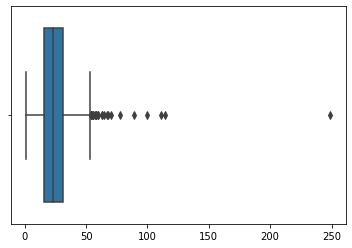

In [91]:
# Checking the lengths of the sentences
lengths = [len(sentence) for sentence in X_train_raw]
lengths.sort()
print(lengths)

sns.boxplot(lengths)

In [92]:
# Maximum words in a sentence
MAX_LENGTH = lengths[-1] 
# Second longest sentence 
PAD_LENGTH = lengths[-2]

print(f'Length of longest sentence: {MAX_LENGTH}')
print(f'Second longest sentence length: {PAD_LENGTH}')

# Padding the sequences
X_train = pad_sequences(X_train_np, maxlen=PAD_LENGTH, padding='post')
X_val = pad_sequences(X_val_np, maxlen=PAD_LENGTH, padding='post')
X_test = pad_sequences(X_test_np, maxlen=PAD_LENGTH, padding='post')

y_train = pad_sequences(y_train_np, maxlen=PAD_LENGTH, padding='post')
y_val = pad_sequences(y_val_np, maxlen=PAD_LENGTH, padding='post')
y_test = pad_sequences(y_test_np, maxlen=PAD_LENGTH, padding='post')

print('-Padded')
print('\tX:',X_train[0])
print('\n\ty:',y_train[0])

Length of longest sentence: 249
Second longest sentence length: 114
-Padded
	X: [400001 400002      2   4979     83    168      2     44   1430      1
    535     20      8 128565    370 400003   1264      3      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]

	y: [21 21  4 10 23 15  4 19 35 11 20 14 11 15 20 21 10  7  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

In [93]:
# One hot encoding the sets
y_train_one_hot = to_categorical(y_train, len(tag2index))
y_val_one_hot = to_categorical(y_val, len(tag2index))
y_test_one_hot = to_categorical(y_test, len(tag2index))

## 2. GloVe 
GloVe (Global Vectors for Word Representation) is a method for learning vector representations of words, called "word embeddings," from a large corpus of text. Word embeddings are numerical representations of words that capture the semantic relationships between words in a continuous, low-dimensional space. They are commonly used as input to natural language processing models, such as language translation and language modeling.

GloVe works by learning the co-occurrence statistics of words in a corpus, and using this information to learn word embeddings that capture the semantic relationships between words. The GloVe method produces word embeddings that are trained on a global corpus, as opposed to embeddings that are trained on a specific task or dataset.

There are different versions of the GloVe word embeddings, including 50-dimensional, 100-dimensional, and 200-dimensional embeddings. The 50-dimensional version of GloVe embeddings may be better in some applications because they have a lower dimensionality, which can make them easier to work with and more computationally efficient.

By using GloVe embeddings as the initial weights for a model, we can take advantage of these pre-trained word representations and fine-tune them for a specific task.

In [94]:
#Building the Embedding Layer 
embedding_matrix = np.zeros((len(word2index), embedding_dim))
for word, i in word2index.items():
  if word != '-PAD-':
    embedding_vector = embedding_dict.get(word)
    embedding_matrix[i] = embedding_vector

## 3. Model
### 3.1 Baseline 
Bidirectional LSTM layers are able to process sequential data in both the forward and backward directions, which can allow the model to capture contextual information from both the past and the future. This can be particularly useful for natural language processing tasks, where the meaning of a word can depend on the context in which it is used.

In the context of POS tagging, TimeDistributed can be used to apply a tag prediction layer to each word in a sentence. For example, you might have an RNN that processes a sequence of words in a sentence, and at each time step, the RNN outputs a hidden state. You could then apply a TimeDistributed dense layer to the hidden states, which would allow you to predict the POS tag for each word in the sentence.

One advantage of using TimeDistributed for POS tagging is that it allows you to predict the POS tag for each word in the sentence simultaneously, rather than having to process the sentence one word at a time. This can be particularly useful when dealing with long sentences, as it can make the tagging process more efficient.

Overall, using TimeDistributed for POS tagging can help you build more accurate and efficient models for natural language processing tasks that involve sequential data.

In [95]:
# List of tags to ignore
ignore = [':', '#', '$', '-LRB-', '-RRB-', ',', '.', "''", '``', 'SYM','-PAD-']

LR = 0.05

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True,verbose=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, verbose=True, min_lr=0.001)
]

In [96]:
# Define the model
baseline_model = Sequential(name='Baseline')

# Add the Embedding layer
baseline_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights=[embedding_matrix], input_length=PAD_LENGTH, trainable=False))


# Add the Bidirectional LSTM layer
baseline_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add the Dense/Fully-Connected layer
baseline_model.add(TimeDistributed(Dense(units=len(tag2index), activation='softmax')))

# Compile the model
baseline_model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])


# Summary
baseline_model.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 114, 300)          121123800 
                                                                 
 bidirectional_7 (Bidirectio  (None, 114, 512)         1140736   
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 114, 46)          23598     
 tributed)                                                       
                                                                 
Total params: 122,288,134
Trainable params: 1,164,334
Non-trainable params: 121,123,800
_________________________________________________________________


In [97]:
# Setting seed for reproducibility
np.random.seed(42)

# Fitting the model
results_baseline = baseline_model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),\
                                      batch_size=128, epochs=20, callbacks=callbacks)

Epoch 1/20
16/16 [==============================] - 31s 2s/step - loss: 1.9890 - accuracy: 0.7453 - ignore_accuracy: 0.2281 - val_loss: 0.2801 - val_accuracy: 0.9239 - val_ignore_accuracy: 0.5297 - lr: 0.0500
Epoch 2/20
16/16 [==============================] - 28s 2s/step - loss: 0.1792 - accuracy: 0.9509 - ignore_accuracy: 0.6473 - val_loss: 0.1301 - val_accuracy: 0.9629 - val_ignore_accuracy: 0.7098 - lr: 0.0500
Epoch 3/20
16/16 [==============================] - 27s 2s/step - loss: 0.0844 - accuracy: 0.9765 - ignore_accuracy: 0.7633 - val_loss: 0.0910 - val_accuracy: 0.9746 - val_ignore_accuracy: 0.7636 - lr: 0.0500
Epoch 4/20
16/16 [==============================] - 28s 2s/step - loss: 0.0493 - accuracy: 0.9864 - ignore_accuracy: 0.8091 - val_loss: 0.0777 - val_accuracy: 0.9785 - val_ignore_accuracy: 0.7819 - lr: 0.0500
Epoch 5/20
16/16 [==============================] - 28s 2s/step - loss: 0.0333 - accuracy: 0.9912 - ignore_accuracy: 0.8316 - val_loss: 0.0709 - val_accuracy: 0.980

In [98]:
# Obtain the predictions made by the model on the validation set
from sklearn.metrics import f1_score

scores_bl = baseline_model.evaluate(X_val, y_val_one_hot, return_dict = True)

predictions_bl_one_hot_encode = baseline_model.predict(X_val)

# Convert the class probabilities into class labels
predictions_bl = np.argmax(predictions_bl_one_hot_encode, axis=-1)

# Create a binary mask for the classes to exclude
mask = np.logical_not(np.isin(y_val, [tag2index[tag] for tag in ignore]))

# Use the mask to exclude the classes that are in the list from the true positive, false positive, and false negative counts
macro_f1_bl = f1_score(y_val[mask], predictions_bl[mask], average='macro')

print(macro_f1_bl)

41/41 [==============================] - 8s 172ms/step
0.6603539834597483


### 3.2 GRU 
Gated Recurrent Units (GRUs) are a type of recurrent neural network (RNN) that are often used in natural language processing tasks such as part-of-speech (POS) tagging. GRUs are similar to long short-term memory (LSTM) networks, but they have a simpler structure and fewer parameters, making them easier to train and faster to run. In POS tagging, GRUs can be used to process a sequence of words and predict the POS tags for each word in the sequence. GRUs are able to take into account contextual information from the previous words in the sequence, allowing them to make more accurate predictions about the POS tags for the current word. 

Both BiLSTMs (Bidirectional LSTMs) and Gated Recurrent Units (GRUs) have been shown to perform well on a variety of NLP tasks, including POS tagging, but here we obtained slightly better results than with the baseline; the reason may be that LSTMs are are particularly well-suited for tasks that require the model to remember and make use of long-term dependencies in the data, while the longest sentence in the Penn Treebank dataset has only 171 words and the average of words per sentence is around 20.  

In [99]:
# Define the model
gru_model = tf.keras.Sequential(name='GRU')

# Add the Embedding layer
gru_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights = [embedding_matrix], input_length = PAD_LENGTH, trainable=False ))

# Add the GRU layer
gru_model.add(GRU(units=256, return_sequences=True))

# Add the Dense/Fully-Connected layer
gru_model.add(TimeDistributed(Dense(len(tag2index), activation='softmax')))

# Compile the model
gru_model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
gru_model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 114, 300)          121123800 
                                                                 
 gru_1 (GRU)                 (None, 114, 256)          428544    
                                                                 
 time_distributed_9 (TimeDis  (None, 114, 46)          11822     
 tributed)                                                       
                                                                 
Total params: 121,564,166
Trainable params: 440,366
Non-trainable params: 121,123,800
_________________________________________________________________


In [100]:
# Setting seed for reproducibility
np.random.seed(42)

# Fitting the model
results_gru = gru_model.fit(X_train, y_train_one_hot, epochs=20, verbose = True, validation_data=(X_val, y_val_one_hot), batch_size=128, callbacks = callbacks)

Epoch 1/20
16/16 [==============================] - 14s 775ms/step - loss: 1.2559 - accuracy: 0.7886 - ignore_accuracy: 0.3463 - val_loss: 0.2367 - val_accuracy: 0.9353 - val_ignore_accuracy: 0.5817 - lr: 0.0500
Epoch 2/20
16/16 [==============================] - 11s 687ms/step - loss: 0.1685 - accuracy: 0.9527 - ignore_accuracy: 0.6534 - val_loss: 0.1398 - val_accuracy: 0.9599 - val_ignore_accuracy: 0.6968 - lr: 0.0500
Epoch 3/20
16/16 [==============================] - 11s 709ms/step - loss: 0.0962 - accuracy: 0.9722 - ignore_accuracy: 0.7435 - val_loss: 0.1109 - val_accuracy: 0.9683 - val_ignore_accuracy: 0.7357 - lr: 0.0500
Epoch 4/20
16/16 [==============================] - 11s 714ms/step - loss: 0.0666 - accuracy: 0.9809 - ignore_accuracy: 0.7839 - val_loss: 0.0979 - val_accuracy: 0.9725 - val_ignore_accuracy: 0.7551 - lr: 0.0500
Epoch 5/20
16/16 [==============================] - 11s 666ms/step - loss: 0.0509 - accuracy: 0.9858 - ignore_accuracy: 0.8069 - val_loss: 0.0876 - val_

In [101]:
scores_gru = gru_model.evaluate(X_val, y_val_one_hot, return_dict = True)

predictions_gru_one_hot_encode = gru_model.predict(X_val)

# Convert the class probabilities into class labels
predictions_gru = np.argmax(predictions_gru_one_hot_encode, axis=-1)

# Create a binary mask for the classes to exclude
mask = np.logical_not(np.isin(y_val, [tag2index[tag] for tag in ignore]))

# Use the mask to exclude the classes that are in the list from the true positive, false positive, and false negative counts
macro_f1_gru = f1_score(y_val[mask], predictions_gru[mask], average='macro')

print(macro_f1_gru)

41/41 [==============================] - 3s 77ms/step
0.5929510836816578


### 3.3 Additional LSTM layer 
Using two BiLSTMs layers can allow the model to learn more complex patterns in the data and make more accurate predictions. 
However, they can increase the computational complexity of our model, which may require more computational resources to train.

With the same number of epochs the results were similar to the baseline and the training process was slower; it is possible that the model with two BiLSTMs is more prone to overfitting, meaning that it is able to fit the training data very well but is less able to generalize to new data. Another possibility is that the model with two BiLSTMs simply takes longer to train. That is why we raised the training epochs to 20, obtaining better results.

In [ ]:
LR = 0.01

# Define the model
add_lstm_model = tf.keras.Sequential(name='Additional_LSTM')

# Add the Embedding layer
add_lstm_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights = [embedding_matrix], input_length = PAD_LENGTH, trainable=False))

# Add the Bidirectional LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add another LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add the Dense/Fully-Connected layer
add_lstm_model.add(TimeDistributed(Dense(units=len(tag2index), activation='softmax')))

# Compile the model
add_lstm_model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
add_lstm_model.summary()

In [ ]:
#Setting seed for reproducibility
np.random.seed(42)

# Fitting the model
results_add_lstm = add_lstm_model.fit(X_train, y_train_one_hot, epochs=30, verbose = True, validation_data=(X_val, y_val_one_hot), batch_size=128, callbacks = callbacks)

Epoch 1/30
16/16 [==============================] - 81s 5s/step - loss: 1.5232 - accuracy: 0.7352 - ignore_accuracy: 0.0768 - val_loss: 0.6535 - val_accuracy: 0.8230 - val_ignore_accuracy: 0.1588 - lr: 0.0100
Epoch 2/30
16/16 [==============================] - 72s 5s/step - loss: 0.6046 - accuracy: 0.8330 - ignore_accuracy: 0.1760 - val_loss: 0.5383 - val_accuracy: 0.8598 - val_ignore_accuracy: 0.2919 - lr: 0.0100
Epoch 3/30
16/16 [==============================] - 72s 5s/step - loss: 0.4532 - accuracy: 0.8761 - ignore_accuracy: 0.3332 - val_loss: 0.3738 - val_accuracy: 0.8923 - val_ignore_accuracy: 0.3915 - lr: 0.0100
Epoch 4/30
16/16 [==============================] - 72s 5s/step - loss: 0.3068 - accuracy: 0.9111 - ignore_accuracy: 0.4751 - val_loss: 0.2610 - val_accuracy: 0.9278 - val_ignore_accuracy: 0.5497 - lr: 0.0100
Epoch 5/30
16/16 [==============================] - 72s 5s/step - loss: 0.2087 - accuracy: 0.9438 - ignore_accuracy: 0.6160 - val_loss: 0.1781 - val_accuracy: 0.951

In [ ]:
scores_add_lstm = add_lstm_model.evaluate(X_val, y_val_one_hot, return_dict = True)

predictions_add_lstm_one_hot_encode = add_lstm_model.predict(X_val)

# Convert the class probabilities into class labels
predictions_add_lstm = np.argmax(predictions_add_lstm_one_hot_encode, axis=-1)

# Create a binary mask for the classes to exclude
mask = np.logical_not(np.isin(y_val, [tag2index[tag] for tag in ignore]))

# Use the mask to exclude the classes that are in the list from the true positive, false positive, and false negative counts
macro_f1_add_lstm = f1_score(y_val[mask], predictions_add_lstm[mask], average='macro')

print(macro_f1_add_lstm)

### 3.4 Additional dense layer

Using two dense layers, one with a non-linear activation function and one with a softmax activation function, is a common pattern in neural network architectures for classification tasks.

The purpose of the non-linear dense layer is to introduce non-linearity into the model, which can allow the model to learn more complex patterns in the data. Common choices for the activation function in this layer include ReLU (Rectified Linear Unit), sigmoid, and tanh.

The purpose of the softmax dense layer is to produce a probability distribution over the possible classes. The softmax activation function transforms the output of the preceding layer into a probability distribution, where the sum of the probabilities is equal to 1. This is useful for classification tasks, where you want to predict the probability that an input belongs to each of the possible classes. Using two dense layers in this way can allow the model to learn more complex patterns in the data and make more accurate predictions.

We have increased the number of training epochs to 15 for the same reasons as before.

In [ ]:
LR = 0.015

# Define the model
add_fc_model = tf.keras.Sequential(name='Additional_FC')

# Add the Embedding layer
add_fc_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights = [embedding_matrix], input_length = PAD_LENGTH, trainable=False))

# Add the Bidirectional LSTM layer
add_fc_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add another Dense layer
add_fc_model.add(TimeDistributed(Dense(units=PAD_LENGTH, activation='relu')))

# Add the Dense/Fully-Connected layer
add_fc_model.add(TimeDistributed(Dense(units=len(tag2index), activation='softmax')))

# Compile the model
add_fc_model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
add_fc_model.summary()

In [ ]:
#Setting seed for reproducibility
np.random.seed(42)

# FItting the model
results_add_fc = add_fc_model.fit(X_train, y_train_one_hot, epochs=30, verbose = True, validation_data=(X_val, y_val_one_hot), batch_size=128, callbacks = callbacks)

In [ ]:
scores_add_fc = add_fc_model.evaluate(X_val, y_val_one_hot, return_dict = True)

predictions_add_fc_one_hot_encode = add_fc_model.predict(X_val)

# Convert the class probabilities into class labels
predictions_add_fc = np.argmax(predictions_add_fc_one_hot_encode, axis=-1)

# Create a binary mask for the classes to exclude
mask = np.logical_not(np.isin(y_val, [tag2index[tag] for tag in ignore]))

# Use the mask to exclude the classes that are in the list from the true positive, false positive, and false negative counts
macro_f1_add_fc = f1_score(y_val[mask], predictions_add_fc[mask], average='macro')

print(macro_f1_add_fc)

## 4. Comparisons


In [ ]:
# Sample data
data = [macro_f1_bl,macro_f1_gru,macro_f1_add_lstm,macro_f1_add_fc]

# Create figure
fig = go.Figure(data=[go.Bar(x=['Baseline','GRU', 'Add. LSTM', 'Add. FC'], y=data)])

# Set titles for axes
fig.update_layout(xaxis_title='Models', yaxis_title='Macro F1')

# Show plot
fig.show()


In [ ]:
#Test phrase
np.random.seed(42)
idx = np.random.randint(0, len(X_val_np))

print(f'Test sentence: {[index2word[word] for word in X_val_np[idx]]}') 

#ground truth
print(f'Ground truth tags: {[index2tag[tag] for tag in y_val_np[idx]]}')

#test bl
print(f'Baseline predictions: {[index2tag[tag] for tag in predictions_bl[idx]]}')
#test gru
print(f'GRU predictions: {[index2tag[tag] for tag in predictions_gru[idx]]}')
#test add lstm
print(f'Additional LSTM layer predictions: {[index2tag[tag] for tag in predictions_add_lstm[idx]]}')
#test add fc
print(f'Additional FC layer predictions: {[index2tag[tag] for tag in predictions_add_fc[idx]]}')



In [ ]:
#Computing macro scores on test set
#Additional LSTM layer
scores_add_lstm = add_lstm_model.evaluate(X_test, y_test_one_hot, return_dict = True)

predictions_add_lstm_one_hot_encode = add_lstm_model.predict(X_test)

# Convert the class probabilities into class labels
predictions_add_lstm = np.argmax(predictions_add_lstm_one_hot_encode, axis=-1)

# Create a binary mask for the classes to exclude
mask = np.logical_not(np.isin(y_test, [tag2index[tag] for tag in ignore]))

# Use the mask to exclude the classes that are in the list from the true positive, false positive, and false negative counts
macro_f1_add_lstm = f1_score(y_test[mask], predictions_add_lstm[mask], average='macro')

print(macro_f1_add_lstm)

In [ ]:
#Computing macro scores on test set
#Additional FC layer
scores_add_fc = add_fc_model.evaluate(X_test, y_test_one_hot, return_dict = True)

predictions_add_fc_one_hot_encode = add_fc_model.predict(X_test)

# Convert the class probabilities into class labels
predictions_add_fc = np.argmax(predictions_add_fc_one_hot_encode, axis=-1)

# Create a binary mask for the classes to exclude
mask = np.logical_not(np.isin(y_test, [tag2index[tag] for tag in ignore]))

# Use the mask to exclude the classes that are in the list from the true positive, false positive, and false negative counts
macro_f1_add_fc = f1_score(y_test[mask], predictions_add_fc[mask], average='macro')

print(macro_f1_add_fc)

In [51]:
# # Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_baseline.history['val_accuracy'])+1))

# # Create a Plotly line plot using the epochs and validation accuracy data
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=results_baseline.history['val_accuracy'], name='Baseline - BiLSTM Model', mode='lines+markers'))
fig.add_trace(go.Scatter(x=epochs, y=results_gru.history['val_accuracy'], name='GRU Model', mode='lines+markers'))
fig.show()

# Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_add_lstm.history['val_accuracy'])+1))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=epochs, y=results_add_lstm.history['val_accuracy'], name='2 BiLSTMs Model', mode='lines+markers'))
fig2.add_trace(go.Scatter(x=epochs, y=results_add_fc.history['val_accuracy'], name='2 FCs Model', mode='lines+markers'))
fig2.show()